#  RAG 답변 평가 (정량적 지표 활용)

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [ ]:
from dotenv import load_dotenv
load_dotenv()

`(2) 기본 라이브러리`

In [ ]:
import os
import json
import time
from typing import List, Dict, Any, Optional
from pprint import pprint

# LangChain 핵심
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# 외부 모델
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_community.document_transformers import EmbeddingsRedundantFilter

# 벡터 저장소
from langchain_chroma import Chroma

# 데이터 분석 및 시각화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # 한글 폰트 인식 - Windows
# import matplotlib 
# font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
# matplotlib.rc('font', family=font_name)

# 한글 폰트 인식 - Mac
import matplotlib
matplotlib.rc('font', family='AppleGothic')

# 마이너스 부호 인식
matplotlib.rc("axes", unicode_minus = False)


In [ ]:
from langfuse.langchain import CallbackHandler

# LangChain 콜백 핸들러 생성
langfuse_handler = CallbackHandler()

In [ ]:
# Langsmith tracing 여부를 확인 (true: langsmith 추적 활성화, false: langsmith 추적 비활성화)
print("langsmith 추적 여부: ", os.getenv('LANGSMITH_TRACING'))

`(3) Test Data`

In [ ]:
# Test 데이터셋에 대한 QA 생성 결과를 리뷰한 후 다시 로드
import pandas as pd
df_qa_test = pd.read_csv("data/synthetic_testset.csv")

print(f"테스트셋: {df_qa_test.shape[0]}개 문서")
df_qa_test.head(2)

In [ ]:
# Evaluaiton 데이터셋에 RAGAS 평가 결과를 로드

ragas_evaluation = pd.read_csv('data/ragas_evaluation_results.csv')
ragas_evaluation.head(2)

---

## **평가 지표** (Evaluation Metric)

#### 1) **검색(Retrieval) 평가**  

- **Non-Rank Based Metrics**: Accuracy, Precision, Recall@k 등을 통해 관련성의 이진적 평가를 수행  

- **Rank-Based Metrics**: MRR(Mean Reciprocal Rank), MAP(Mean Average Precision)를 통해 검색 결과의 순위를 고려한 평가를 수행

- **RAG 특화 지표**: 기존 검색 평가 방식의 한계를 보완하는 LLM-as-judge 방식 도입

- **포괄적 평가**: 정확도, 관련성, 다양성, 강건성을 통합적으로 측정

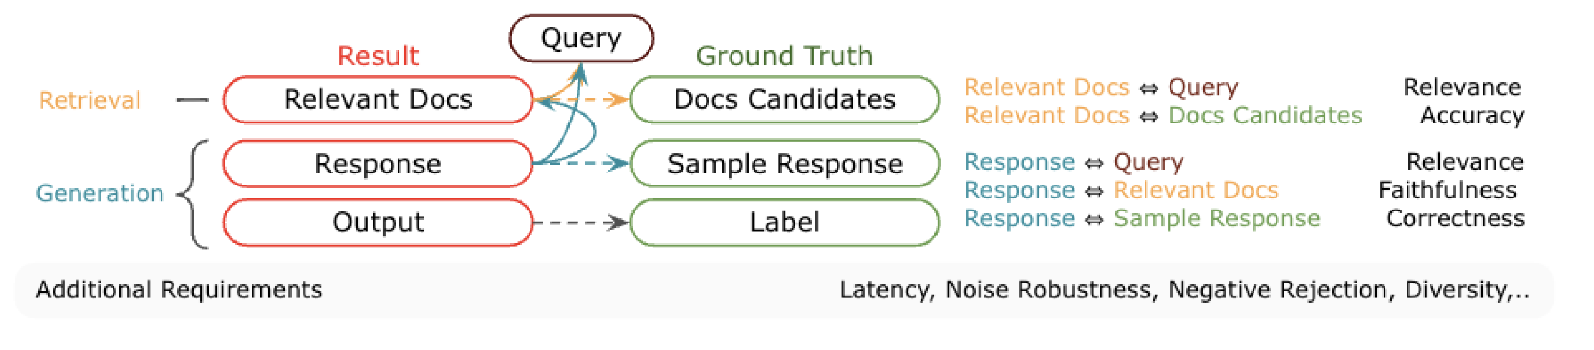

#### 2) **생성(Generation) 평가**

- **전통적 평가**: ROUGE(요약), BLEU(번역), BertScore(의미 유사도) 지표 활용

- **LLM 기반 평가**: 응집성, 관련성, 유창성을 종합적으로 판단하는 새로운 접근법 도입 (전통적인 참조 비교가 어려운 상황에서 유용)

- **다차원 평가**: 품질, 일관성, 사실성, 가독성, 사용자 만족도를 포괄적 측정

- **상세 프롬프트**와 **사용자 선호도** 기준으로 생성 텍스트 품질 평가


[출처] https://arxiv.org/abs/2405.07437

---

## **검색 도구 정의** 

### 1) **벡터스토어** 로드

- **Chroma DB** 설정에서 모델, 컬렉션명, 저장 경로 지정

In [ ]:
def initialize_vector_store(embeddings = OpenAIEmbeddings(model="text-embedding-3-small"), collection_name="hybrid_search_db", persist_directory = "./local_chroma_db"):
    """
    기존 벡터 저장소를 로드하거나 새로 생성
    
    Returns:
        Chroma: 벡터 저장소 객체
    """
    try:
        
        # 기존 벡터 저장소 로드 시도
        vector_store = Chroma(
            collection_name=collection_name,
            embedding_function=embeddings,
            persist_directory=persist_directory,
        )
        
        doc_count = vector_store._collection.count()
        if doc_count > 0:
            print(f"✅ 기존 벡터 저장소 로드: {doc_count}개 문서")
            return vector_store
        else:
            print("⚠️ 빈 벡터 저장소입니다. 데이터를 추가해주세요.")
            return vector_store
            
    except Exception as e:
        print(f"❌ 벡터 저장소 로드 실패: {e}")
        return None

# 벡터 저장소 초기화
chroma_db = initialize_vector_store()

In [ ]:
# 벡터저장소 검색기 생성
chroma_k = chroma_db.as_retriever(
    search_kwargs={'k': 4},
)

# 벡터저장소 검색기를 사용하여 검색
query = "테슬라의 회장은 누구인가요?"

retrieved_docs = chroma_k.invoke(query)

# 검색 결과 출력
for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-"*200)
    print()

## **RAG Chain** 정의

- OpenAI gpt-4.1-mini 모델 활용

In [ ]:
# 각 쿼리에 대한 검색 결과를 한꺼번에 Context로 전달해서 답변을 생성
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

def create_rag_chain(retriever, llm):

    template = """Answer the following question based on this context. If the context is not relevant to the question, just answer with '답변에 필요한 근거를 찾지 못했습니다.'

    [Context]
    {context}

    [Question]
    {question}

    [Answer]
    """

    prompt = ChatPromptTemplate.from_template(template)

    def format_docs(docs):
        return "\n\n".join([f"{doc.page_content}" for doc in docs])

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()} 
        | prompt
        | llm
        | StrOutputParser()
    )

    return rag_chain

In [ ]:
# RAG 체인 생성 및 테스트
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.5)

openai_rag_chain = create_rag_chain(chroma_k, llm)

question = "테슬라의 회장은 누구인가요?"
answer = openai_rag_chain.invoke(question)

print(f"쿼리: {question}")
print(f"답변: {answer}") 

---

## **RAG 답변 평가** 

- **정확성**과 **관련성**이 RAG 시스템의 핵심 평가 지표

- **자동 평가**(ROUGE, BLEU)와 **인간 평가** 병행 필요

- **일관성** 측정을 통한 답변의 논리적 모순 확인

- 정량적, 정성적 평가를 종합해 RAG 시스템의 실질적 성능 측정

    - **평가 시스템의 구조**:
        - 입력: 데이터셋 예시와 실행 결과를 포함
        - 출력: key(메트릭명), score/value(점수), comment(설명)를 포함하는 표준화된 형태
        - 구현: Python/TypeScript 기반의 커스텀 코드 또는 LangSmith 내장 평가기 활용

    - **평가 방법의 유형**:
        - 휴리스틱 평가: 답변 길이, JSON 유효성, 코드 문법 등 기본적 규칙 검증
        - 자동화 메트릭: ROUGE, BLEU 등을 통한 정량적 평가
        - LLM-as-judge: LLM을 활용한 출력 품질 평가
        - Pairwise 비교: 두 시스템 출력의 직접적인 비교 평가


- **LangChain 평가도구** 활용
    - **다양한 평가 방식** 지원: Q&A 정확도, 맥락 이해도, 사고 과정 검증
    - **문자열/임베딩 거리** 및 **JSON 평가** 기능 포함
    - `LangChainStringEvaluator`로 **평가도구 설정** 및 **매개변수 조정** 가능
    - 참고: https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators

---
### 1) **휴리스틱 평가** 

- **휴리스틱 평가자**는 특정 규칙에 기반한 **결정론적 함수**로 작동하며, 명확한 기준에 따라 판단을 수행

- 주로 **단순 검증**에 활용되며, 챗봇 응답의 공백 여부, 생성된 코드의 컴파일 가능성 등을 확인

- 평가 기준이 **명확하고 객관적**이어서 정확한 분류나 검증이 필요한 경우에 효과적

- 복잡한 상황보다는 **명확한 규칙**이 존재하는 간단한 검증 작업에 적합

`(1) 답변 길이 평가`

In [ ]:
# 길이 평가도구 정의 
def evaluate_string_length(text, min_length=50, max_length=200):
    length = len(text)
    return {
        "score": min_length <= length <= max_length,
        "length": length
    }

# 길이 평가 수행
print(f"답변: {answer}")

# 길이 평가
result = evaluate_string_length(answer)
print(f"길이 평가 결과: {result}")

In [ ]:
# 토큰 길이 평가도구 정의

def evaluate_token_length(text, tokenizer, min_tokens=10, max_tokens=100):
    tokens = tokenizer.tokenize(text)
    num_tokens = len(tokens)
    return {
        "score": min_tokens <= num_tokens <= max_tokens,
        "num_tokens": num_tokens
    }

# 토큰 길이 평가 수행
from ranx_k.tokenizers import KiwiTokenizer

kiwi_tokenizer = KiwiTokenizer(use_stopwords=False, pos_filter=[]) # POS 필터 미적용
result = evaluate_token_length(answer, kiwi_tokenizer)
print(f"토큰 길이 평가 결과: {result}")

In [ ]:
kiwi_tokenizer.tokenize(answer)

In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate


# 여러 평가 도구를 병렬로 실행하는 함수
def create_evaluator_chain(*evaluator_funcs):
    evaluator_dict = {
        getattr(func, '__name__', f'eval_{i}'): lambda x, func=func: func(x)
        for i, func in enumerate(evaluator_funcs)
    }
    
    return RunnableParallel(evaluator_dict)

# 길이 평가 도구 생성 함수
def create_length_evaluator(min_length=50, max_length=200):
    def evaluate_string_length(text: str):
        length = len(text)
        return {
            "score": min_length <= length <= max_length,
            "length": length
        }
    return evaluate_string_length

# 토큰 길이 평가 도구 생성 함수
def create_token_length_evaluator(tokenizer, min_tokens=10, max_tokens=100):
    def evaluate_token_length(text: str):
        tokens = tokenizer.tokenize(text)
        num_tokens = len(tokens)
        return {
            "score": min_tokens <= num_tokens <= max_tokens,
            "num_tokens": num_tokens
        }
    return evaluate_token_length

# 요약 체인 생성 함수
def create_summary_chain(llm, evaluators=None):
    prompt = ChatPromptTemplate.from_template(
        """제시된 텍스트를 50자 이내로 요약하세요. (공백 포함) 

        [텍스트]
        {text}
        """
    )
    
    base_chain = prompt | llm | StrOutputParser()
    
    if evaluators:
        eval_chain = create_evaluator_chain(*evaluators)
        chain = base_chain | RunnableParallel({
            "answer": RunnablePassthrough(),
            "evaluation": eval_chain
        })
        return chain
    
    return base_chain


# 요약 체인 생성
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.3, max_tokens=100)
evaluators = [
    create_length_evaluator(min_length=30, max_length=50),
    create_token_length_evaluator(kiwi_tokenizer, min_tokens=10, max_tokens=20),
]

summary_chain = create_summary_chain(llm, evaluators)

# 요약 체인 테스트
text = """
테슬라는 미국의 전기 자동차 제조업체이자, 태양광 발전 및 에너지 저장장치 제조업체이다.
테슬라의 창업자이자 CEO인 일론 머스크는 2003년 테슬라를 설립하였다.
테슬라는 2008년 테슬라 로드스터를 출시하며 전기 자동차 시장에 진출하였다.
"""

summary = summary_chain.invoke(text)
print(f"요약: {summary['answer']}")
print(f"평가: {summary['evaluation']}")

`(2) JSON 유효성 평가`

In [ ]:
from langchain.evaluation import load_evaluator

# Evaluator 초기화
json_validity_evaluator = load_evaluator(
    evaluator="json_validity",      # JSON 유효성 검사
    )

# JSON 평가
json_result = json_validity_evaluator.evaluate_strings(
    prediction='{"name": "test", "value": 123}',
    reference=None
)
print(f"JSON 유효성 평가 결과: {json_result}")

---
### 2) **정량 평가지표** 사용

- **ROUGE**와 **BLEU**는 텍스트 생성 품질을 평가하는 대표적인 **정량 평가지표**임 

- 이러한 메트릭들은 생성된 텍스트와 참조 텍스트 간의 **단어 중첩도**를 계산하여 품질을 수치화

- **대규모 자동화 평가**가 필요한 경우 효율적이며, 객관적인 비교가 가능한 장점이 있음

- 하지만, 문맥이나 의미의 유사성은 완벽하게 포착하지 못하는 **한계점**이 존재

    1. 단순 단어 비교만 가능
        - "날씨가 좋다"와 "날씨가 훌륭하다"는 의미는 비슷하지만 다른 점수를 받을 수 있음 

    2. 문맥 이해 불가
        - "강아지가 공을 물었다"와 "공을 강아지가 물었다"는 의미가 같아도 다른 점수를 받을 수 있음

---

- **ROUGE(Recall-Oriented Understudy for Gisting Evaluation)**

    - 생성된 요약문의 품질을 평가

- ROUGE-1:
    - 참조 문서와 생성된 요약문 사이의 단일 단어(unigram) 중복을 측정 
    - 예시: "고양이가 잠을 잡니다"와 "고양이는 낮잠을 잡니다" 비교
        - 참조: ["고양이", "가", "잠", "을", "잡니다"]
        - 생성: ["고양이", "는", "낮잠", "을", "잡니다"]
        - 일치: ["고양이", "을", "잡니다"]
        - Precision = 3/5 = 0.6
        - Recall = 3/5 = 0.6
        - F1 = 0.6

- ROUGE-2:
    - 연속된 두 단어(bigram) 시퀀스의 중복을 평가
    - 예시: "고양이가 잠을 잡니다"와 "고양이는 낮잠을 잡니다" 비교
        - 참조: ["고양이 가", "가 잠", "잠 을", "을 잡니다"]
        - 생성: ["고양이 는", "는 낮잠", "낮잠 을", "을 잡니다"]
        - 일치: ["을 잡니다"]
        - Precision = 1/4 = 0.25
        - Recall = 1/4 = 0.25
        - F1 = 0.25

- ROUGE-L:
    - 최장 공통 부분수열(LCS)을 기반으로 텍스트의 유사도를 측정
    - 예시: "고양이가 잠을 잡니다"와 "고양이는 낮잠을 잡니다" 비교
        - 참조: "고양이 가 잠 을 잡니다"
        - 생성: "고양이 는 낮잠 을 잡니다"
        - LCS: "고양이 을 잡니다"
        - Precision = 3/5 = 0.6
        - Recall = 3/5 = 0.6
        - F1 = 0.6

- 각 메트릭은 정밀도(Precision), 재현율(Recall), F1-score로 표현
- ROUGE-1은 개별 단어 일치를, ROUGE-2는 문장 구조를, ROUGE-L은 전체적인 의미 유사성을 중점적으로 평가

---

- **BLEU (Bilingual Evaluation Understudy)**

    - BLEU는 기계 번역의 품질을 평가하는 대표적인 메트릭으로, 생성된 번역문과 참조 번역문 간의 n-gram 정확도를 계산
    - 0에서 1 사이의 값을 가지며, 1에 가까울수록 번역 품질이 좋음을 의미

- BLEU-1 (단일 단어):
    - 예시: "나는 학교에 간다" vs "나는 학원에 간다"
        - 참조: ["나는", "학교에", "간다"]
        - 생성: ["나는", "학원에", "간다"]
        - 일치: ["나는", "간다"]
        - Precision = 2/3 = 0.67
        - BP(Brevity Penalty) = 1 (같은 길이)
        - BLEU-1 = 0.67

- BLEU-2 (두 단어 시퀀스):
    - 예시: "나는 학교에 간다" vs "나는 학원에 간다"
        - 참조의 bigram: ["나는 학교에", "학교에 간다"]
        - 생성의 bigram: ["나는 학원에", "학원에 간다"]
        - 일치하는 bigram: 없음
        - Precision = 0/2 = 0
        - BP = 1
        - BLEU-2 = 0

- BLEU-3 (세 단어 시퀀스):
    - 예시: "나는 학교에 간다" vs "나는 학원에 간다"
        - 참조의 trigram: ["나는 학교에 간다"]
        - 생성의 trigram: ["나는 학원에 간다"]
        - 일치하는 trigram: 없음
        - Precision = 0/1 = 0
        - BP = 1
        - BLEU-3 = 0

- 주요 특징:
    1. Brevity Penalty(BP):
        - 생성문이 참조문보다 짧을 경우 페널티 부여
        - BP = min(1, exp(1 - 참조문길이/생성문길이))

    2. 최종 BLEU 점수:
        - 일반적으로 BLEU-1부터 BLEU-4까지의 기하평균 사용
        - BLEU = BP × exp(∑(wn × log(pn)))
        - wn은 각 n-gram의 가중치 (보통 균등 가중치 0.25 사용)

    3. ROUGE와의 차이점:
        - BLEU는 Precision 중심, ROUGE는 Recall 중심
        - BLEU는 기계 번역 평가에 주로 사용
        - BLEU는 항상 BP(Brevity Penalty)를 고려함
        - BLEU는 여러 n-gram의 기하평균을 사용

`(1) ROUGE 스코어`

   - **ROUGE-1**: 한 단어씩 비교 (예: "날씨가", "좋습니다" 등)
   - **ROUGE-2**: 두 단어(bigram)씩 연속으로 비교 (예: "날씨가 좋습니다")
   - **ROUGE-L**: 가장 긴 공통 단어열(LCS)을 찾아 비교

  - 자동 요약과 기계 번역 평가에 사용

In [ ]:
from rouge_score import rouge_scorer
from ranx_k.tokenizers import KiwiTokenizer


# 토크나이저 생성
kiwi_tokenizer = KiwiTokenizer(use_stopwords=False, pos_filter=[]) # POS 필터 미적용

# ROUGE 스코어 계산
scorer = rouge_scorer.RougeScorer(
    ["rouge1", "rouge2", "rougeL"], 
    tokenizer=kiwi_tokenizer      # tokenize 메소드를 갖는 토크나이저 사용
)

# 예시 데이터 
reference = "오늘 날씨가 매우 좋습니다. 공원에서 산책하기 좋은 날이에요."   # 정답 텍스트
generated1 = "오늘은 날씨가 정말 좋네요. 공원에서 산책하면 좋을 것 같아요." # 생성된 텍스트
generated2 = "비가 많이 오고 있어요. 실내에서 쉬는 게 좋을 것 같습니다."   # 생성된 텍스트

print("=== 유사한 텍스트 비교 ===")
rouge_scores = scorer.score(reference, generated1)

print(f"ROUGE-1: {rouge_scores['rouge1'].fmeasure:.3f}")
print(f"ROUGE-2: {rouge_scores['rouge2'].fmeasure:.3f}")
print(f"ROUGE-L: {rouge_scores['rougeL'].fmeasure:.3f}")

print("\n=== 다른 텍스트 비교 ===")
rouge_scores = scorer.score(reference, generated2)

print(f"ROUGE-1: {rouge_scores['rouge1'].fmeasure:.3f}")
print(f"ROUGE-2: {rouge_scores['rouge2'].fmeasure:.3f}")
print(f"ROUGE-L: {rouge_scores['rougeL'].fmeasure:.3f}")

`(2) BLEU (Bilingual Evaluation Understudy)`
   
   - 생성된 텍스트가 얼마나 자연스러운지를 평가
   - 0부터 1 사이의 값으로 표시 (1에 가까울수록 좋음)

  - 기계 번역 평가의 대표적 지표
  - n-gram 정밀도 기반
  - 간결성 페널티 적용
  - 1-4gram까지의 기하평균 사용


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from typing import List, Union

# BLEU 스코어 계산
def calculate_bleu_score(
    reference: Union[str, List[str]], 
    hypothesis: str,
    weights: tuple = (0.25, 0.25, 0.25, 0.25),  # n-gram 가중치 설정 (기본값: 균등 가중치)
    smoother=SmoothingFunction().method1,  # Smoothing 메소드 설정 -> method1 사용 (0으로 나누는 것 방지)
    tokenizer=kiwi_tokenizer # Kiwi 토크나이저 사용 
) -> float:
    """
    BLEU 스코어 계산
    
    Args:
        reference (Union[str, List[str]]): 참조 텍스트 또는 텍스트 리스트
        hypothesis (str): 비교할 생성 텍스트
        weights (tuple): n-gram 가중치 (기본값: 균등 가중치)
        tokenizer: 토크나이저 객체 (기본값: Kiwi 토크나이저)
        
    Returns:
        float: BLEU 스코어 (0~1)
    """
    try:
        # 참조 텍스트 처리
        if isinstance(reference, str):
            references = [tokenizer.tokenize(reference)]
        else:
            references = [tokenizer.tokenize(ref) for ref in reference]
        
        # 생성 텍스트 토크나이징
        hypothesis_tokens = tokenizer.tokenize(hypothesis)
        
        # BLEU 스코어 계산
        score = sentence_bleu(
            references,
            hypothesis_tokens,
            weights=weights,
            smoothing_function=smoother
        )
        
        return score
        
    except Exception as e:
        print(f"BLEU 스코어 계산 중 오류 발생: {str(e)}")
        return 0.0



# 예시 데이터 
reference = "오늘 날씨가 매우 좋습니다. 공원에서 산책하기 좋은 날이에요."   # 정답 텍스트
generated1 = "오늘은 날씨가 정말 좋네요. 공원에서 산책하면 좋을 것 같아요." # 생성된 텍스트
generated2 = "비가 많이 오고 있어요. 실내에서 쉬는 게 좋을 것 같습니다."   # 생성된 텍스트

print("=== 유사한 텍스트 비교 ===")
bleu_score = calculate_bleu_score(reference, generated1, tokenizer=kiwi_tokenizer)
print(f"BLEU: {bleu_score:.3f}")

print("\n=== 다른 텍스트 비교 ===")
bleu_score = calculate_bleu_score(reference, generated2, tokenizer=kiwi_tokenizer)
print(f"BLEU: {bleu_score:.3f}")

### 3) **문자열 및 임베딩 거리** 평가

- **문자열 및 임베딩 거리**는 예측값과 참조값 간의 유사도를 **정량적으로 측정**하는 평가 방식

- **String Distance Evaluator**는 레벤슈타인 거리 등을 활용해 문자열 간의 **편집 거리**를 계산하며, 정규화된 점수를 제공함

- **Embedding Distance Evaluator**는 텍스트의 **의미적 유사도**를 코사인 거리 등 다양한 메트릭으로 측정함

- 문자열과 임베딩 기반 평가 방식은 예측값의 정확도를 객관적으로 측정할 수 있으며, 유연한 커스터마이징이 가능함 

`(1) String Distance`

- **String Distance Evaluator**는 **레벤슈타인 거리**를 사용해 두 문자열이 얼마나 다른지 측정

- 한 문자열을 다른 문자열로 변환하는데 필요한 **최소 편집 횟수**를 계산

- 점수는 **0에서 1 사이로 정규화**되어 제공되며, 0에 가까울수록 문자열이 유사함을 의미

- `rapidfuzz` 라이브러리를 통해 **효율적인 계산**이 가능하며, 대규모 평가에 적합 (설치 필요)
    - pip install --upgrade --quiet  rapidfuzz (또는 poetry add rapidfuzz)

In [ ]:
from langchain.evaluation import load_evaluator

# 문자열 거리 기반 평가기 생성
string_distance_evaluator = load_evaluator(
    evaluator="string_distance",
    distance="levenshtein"    # damerau_levenshtein, levenshtein, jaro, jaro_winkler
)

# 문자열 거리 기반 평가기를 사용하여 평가 (일치하는 사례)
result = string_distance_evaluator.evaluate_strings(
    prediction= "네, 오늘은 날씨가 맑고 좋네요",
    reference="네, 오늘은 날씨가 맑고 좋네요"
)

# 평가 결과 출력
print(result)

In [ ]:
# 문자열 거리 기반 평가자를 사용하여 평가 (불일치하는 사례)
result = string_distance_evaluator.evaluate_strings(
    prediction= "해당 제품의 가격은 50,000원입니다",
    reference="이 제품의 가격이 얼마인가요?"
)

# 평가 결과 출력
print(result)

`(2) Embedding Distance`

- **임베딩 거리 평가도구**는 텍스트를 **고차원 벡터**로 변환하여 의미적 유사도를 계산

- **코사인 거리**, 유클리디안 거리, 맨해튼 거리 등 **다양한 거리 메트릭**을 선택적으로 활용할 수 있음 

- OpenAI나 HuggingFace 등 다양한 **임베딩 제공자**를 설정할 수 있음 

- 단순 문자열 비교와 달리 **문맥적 의미**를 고려한 평가가 가능함 

In [ ]:
from langchain.evaluation import load_evaluator
from langchain_openai import OpenAIEmbeddings

# Evaluator 초기화
embedding_evaluator = load_evaluator(
    evaluator='embedding_distance',               # 임베딩 거리를 기반으로 평가
    distance_metric='cosine',                     # 거리 측정 방법: cosine, euclidean, manhattan, chebyshev, hamming
    embeddings=OpenAIEmbeddings(model="text-embedding-3-small")   # 기본값: OpenAI 임베딩 모델 사용
)

# 의미가 다른 문장 비교
result1 = embedding_evaluator.evaluate_strings(
    prediction="나는 학교에 갈 것이다", 
    reference="나는 집에 있을 것이다"
    )

print("의미가 다른 문장 비교 결과:", result1)

In [ ]:
# 의미가 비슷한 문장 비교
result2 = embedding_evaluator.evaluate_strings(
    prediction="나는 학교에 갈 것이다", 
    reference="나는 학교로 이동할 것이다",
    )

print("의미가 비슷한 문장 비교 결과:", result2)

---

## **LangChainStringEvaluator**

- **LangSmith**와 연동되어 다양한 **평가 도구를 제공**하는 클래스

- **문자열 거리**, **임베딩 거리**, **LLM 기반 평가** 등 다양한 **내장 평가자**를 쉽게 이용 가능

- 평가 결과는 **LangSmith 플랫폼**에서 체계적으로 관리되고 시각화될 수 있음 

- 사용자 정의 평가자를 만들거나 기존 평가자를 **커스터마이즈**하는 것도 가능함 

`(1) 사전 준비`

- **데이터셋 생성**이 평가 과정의 첫 단계로 요구됨

- **LangSmith 클라이언트** 설정이 평가 시작 전 필수적으로 이루어져야 함

In [ ]:
from langsmith import Client

# Langsmith 클라이언트 초기화
client = Client()

# 유사 문장 데이터셋 정의
similar_sentences = [
    ("오늘 날씨가 좋네요.", "날씨가 정말 좋은 하루네요."),
    ("이 책은 재미있어요.", "이 책이 너무 재미있네요."),
    ("저는 커피를 좋아해요.", "커피를 정말 사랑합니다."),
    ("이 영화 추천해요.", "이 영화 꼭 보시는 걸 추천드립니다."),
    ("서울은 인구가 많아요.", "서울은 사람이 매우 많은 도시예요.")
]

# 데이터셋 생성
dataset_name = "Korean_Similarity_Set_V1"
dataset = client.create_dataset(dataset_name=dataset_name)

# 입력과 출력 데이터 준비
inputs = [{"input_text": input_text} for input_text, _ in similar_sentences]
outputs = [{"similar_text": similar_text} for _, similar_text in similar_sentences]

# 데이터셋에 예제 추가
client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

`(2) 문장 유사도 평가`

In [ ]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate
from langchain_openai import OpenAIEmbeddings

# 문자열 거리 기반 평가
string_distance_evaluator = LangChainStringEvaluator(
    "string_distance",
    config={"distance": "levenshtein", "normalize_score": True},
    prepare_data=lambda run, example: {
        "prediction": run.outputs["predicted_text"],    # 실험을 통해 생성되는 예측값
        "reference": example.outputs["similar_text"],   # 데이터셋에서 제공되는 참조값
    }
)

# 임베딩 거리 기반 평가
embedding_distance_evaluator = LangChainStringEvaluator(
    "embedding_distance",
        config={
        "distance_metric": "cosine",
        "embeddings": OpenAIEmbeddings(model="text-embedding-3-small")
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["predicted_text"],
        "reference": example.outputs["similar_text"],
    }
)

# 평가 실행
def similarity_test(input_data):
    # 여기서는 간단한 예시로 입력 문장을 그대로 반환
    return {"predicted_text": input_data["input_text"]}

evaluation_result = evaluate(
    similarity_test,
    data=dataset_name,
    evaluators=[
        string_distance_evaluator,
        embedding_distance_evaluator
    ]
)

In [ ]:
evaluation_result

---
### **[실습]**

- LangChainStringEvaluator 사용하여 테스트셋의 정답과 openai_rag_chain의 생성된 답변의 품질을 비교 평가합니다. 
- 평가 메트릭: 문자열 거리 기반 평가, 임베딩 거리 기반 평가

In [ ]:
df_qa_test.head(1)

In [ ]:
from langsmith import Client

# Langsmith 클라이언트 초기화
client = Client()

# 데이터셋 생성
dataset_name = "Livian_Tesala_RAG_Test_V1"
dataset = client.create_dataset(dataset_name=dataset_name)

# 입력 데이터 준비
inputs = [{"user_input": user_input, "reference_contexts": reference_contexts} for user_input, reference_contexts in zip(df_qa_test.head()['user_input'], df_qa_test.head()['reference_contexts'])]
outputs = [{"reference": reference} for reference in df_qa_test.head()['reference']]

# 데이터셋에 예제 추가
client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

In [ ]:
# 여기에 평가 함수를 정의하고 실행하세요.

<details>
<summary>💡 정답 보기</summary>

```python
from langsmith.evaluation import LangChainStringEvaluator, evaluate
from langchain_openai import OpenAIEmbeddings

# 문자열 거리 기반 평가
string_distance_evaluator = LangChainStringEvaluator(
    "string_distance",
    config={"distance": "levenshtein", "normalize_score": True},
    prepare_data=lambda run, example: {
        "prediction": run.outputs["predicted_text"],
        "reference": example.outputs["reference"],
    }
)

# 임베딩 거리 기반 평가
embedding_distance_evaluator = LangChainStringEvaluator(
    "embedding_distance",
        config={
        "distance_metric": "cosine",
        "embeddings": OpenAIEmbeddings(model="text-embedding-3-small")
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["predicted_text"],
        "reference": example.outputs["reference"],
    }
)

# 평가 실행
def similarity_test(input_data):
    # RAG 체인을 사용하여 예측 생성
    return {"predicted_text": openai_rag_chain.invoke(input_data["user_input"]) }

evaluation_result = evaluate(
    similarity_test,
    data=dataset_name,
    evaluators=[
        string_distance_evaluator,
        embedding_distance_evaluator
    ]
)
```
</details>
